In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# reading dataset for training (NBA Regular Season matches for last 20 seasons)
raw_data_train = pd.read_csv('~/nba-dl/data/matches/RS/book-RS.csv')
raw_data_train.columns

Index(['SEASON_ID', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME', 'GAME_ID', 'GAME_DATE',
       'HWIN', 'HPLUSMINUS', 'HFGM', 'HFGA', 'HFG_PCT', 'HFG3M', 'HFG3A',
       'HFG3_PCT', 'HFTM', 'HFTA', 'HFT_PCT', 'HOREB', 'HDREB', 'HREB', 'HAST',
       'HSTL', 'HBLK', 'HTOV', 'HPF', 'AFGM', 'AFGA', 'AFG_PCT', 'AFG3M',
       'AFG3A', 'AFG3_PCT', 'AFTM', 'AFTA', 'AFT_PCT', 'AOREB', 'ADREB',
       'AREB', 'AAST', 'ASTL', 'ABLK', 'ATOV', 'APF'],
      dtype='object')

In [3]:
# train data shape
raw_data_train.shape

(24154, 41)

In [4]:
# reading dataset for testing (NBA Playoffs matches for last 20 seasons)
raw_data_test = pd.read_csv('~/nba-dl/data/matches/PO/book-PO.csv')
raw_data_test.columns

Index(['SEASON_ID', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME', 'GAME_ID', 'GAME_DATE',
       'HWIN', 'HPLUSMINUS', 'HFGM', 'HFGA', 'HFG_PCT', 'HFG3M', 'HFG3A',
       'HFG3_PCT', 'HFTM', 'HFTA', 'HFT_PCT', 'HOREB', 'HDREB', 'HREB', 'HAST',
       'HSTL', 'HBLK', 'HTOV', 'HPF', 'AFGM', 'AFGA', 'AFG_PCT', 'AFG3M',
       'AFG3A', 'AFG3_PCT', 'AFTM', 'AFTA', 'AFT_PCT', 'AOREB', 'ADREB',
       'AREB', 'AAST', 'ASTL', 'ABLK', 'ATOV', 'APF'],
      dtype='object')

In [5]:
# test data shape
raw_data_test.shape

(1641, 41)

In [6]:
'''
GLOSSARY:

HWIN     - home team win, W means win, L means loss, later W is mapped to 1, L to 0 - LABEL
HFGM     - home team field goal made
HFGA     - home team field goal attempts
HFG_PCT  - home team percentage field goal
HFG3M    - home team 3PT field goal made
HFG3A    - home team 3PT field goal attempts
HFG3_PCT - home team percentage 3PT field goal
HFTM     - home team free throws made
HFTA     - home team free throws attempts
HFT_PCT  - home team percentage free throws
HOREB    - home team offensive rebounds
HDREB    - home team defensive rebounds
HAST     - home team assists
HSTL     - home team steals
HBLK     - home team blocks
HTOV     - home team turnovers
HPF      - home team personal fouls
AFGM     - away team field goal made
AFGA     - away team field goal attempts
AFG_PCT  - away team percentage field goal
AFG3M    - away team 3PT field goal made
AFG3A    - away team 3PT field goal attempts
AFG3_PCT - away team percentage 3PT field goal
AFTM     - away team free throws made
AFTA     - away team free throws attempts
AFT_PCT  - away team percentage free throws
AOREB    - away team offensive rebounds
ADREB    - away team defensive rebounds
AAST     - away team assists
ASTL     - away team steals
ABLK     - away team blocks
ATOV     - away team turnovers
APF      - away team personal fouls
'''

# selecting numerical features

columns = ['HWIN',
           'HFGM', 'HFGA', 'HFG_PCT', 'HFG3M', 'HFG3A', 'HFG3_PCT', 'HFTM', 'HFTA', 'HFT_PCT',
           'HOREB', 'HDREB', 'HREB', 'HAST', 'HSTL', 'HBLK', 'HTOV', 'HPF',
           'AFGM', 'AFGA', 'AFG_PCT', 'AFG3M', 'AFG3A', 'AFG3_PCT', 'AFTM', 'AFTA', 'AFT_PCT',
           'AOREB', 'ADREB', 'AREB', 'AAST', 'ASTL', 'ABLK', 'ATOV', 'APF']

In [7]:
# making new dataset with selected columns

data_train = raw_data_train[columns]
data_test = raw_data_test[columns]
data_train.head()

,HWIN,HFGM,HFGA,HFG_PCT,HFG3M,HFG3A,HFG3_PCT,HFTM,HFTA,HFT_PCT,...,AFTA,AFT_PCT,AOREB,ADREB,AREB,AAST,ASTL,ABLK,ATOV,APF
0,W,39,79,0.494,4,12,0.333,28,30,0.933,...,21,0.762,14,31,45,26,7,5,15,30
1,W,30,78,0.385,7,19,0.368,23,32,0.719,...,8,0.750,21,39,60,17,5,3,15,24
2,L,40,89,0.449,5,11,0.455,23,29,0.793,...,22,0.727,10,37,47,32,10,3,17,30
3,W,47,79,0.595,4,8,0.500,10,20,0.500,...,28,0.679,10,18,28,20,9,4,16,25
4,L,38,92,0.413,4,15,0.267,20,25,0.800,...,35,0.771,12,26,38,26,6,3,17,20


In [8]:
# mapping labels to numeric values

data_train['HWIN'] = data_train['HWIN'].map({'W': 1, 'L': 0})
data_test['HWIN'] = data_test['HWIN'].map({'W': 1, 'L': 0})
data_train.head()

/home/jmacek/nba-dl/inz/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jmacek/nba-dl/inz/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,HWIN,HFGM,HFGA,HFG_PCT,HFG3M,HFG3A,HFG3_PCT,HFTM,HFTA,HFT_PCT,...,AFTA,AFT_PCT,AOREB,ADREB,AREB,AAST,ASTL,ABLK,ATOV,APF
0,1,39,79,0.494,4,12,0.333,28,30,0.933,...,21,0.762,14,31,45,26,7,5,15,30
1,1,30,78,0.385,7,19,0.368,23,32,0.719,...,8,0.750,21,39,60,17,5,3,15,24
2,0,40,89,0.449,5,11,0.455,23,29,0.793,...,22,0.727,10,37,47,32,10,3,17,30
3,1,47,79,0.595,4,8,0.500,10,20,0.500,...,28,0.679,10,18,28,20,9,4,16,25
4,0,38,92,0.413,4,15,0.267,20,25,0.800,...,35,0.771,12,26,38,26,6,3,17,20


In [9]:
# separating data to features(X) and labels(y)

X_train = data_train.drop("HWIN", 1)
y_train = data_train["HWIN"]
X_test = data_test.drop("HWIN", 1)
y_test = data_test['HWIN']

In [10]:
# compare feature selection methods
pearson_correlation_features = ['HFGM', 'HFG_PCT', 'HDREB', 'HAST', 'AFGM', 'AFG_PCT', 'ADREB']
univariate_selection_features = ['HAST', 'AAST', 'ADREB', 'HDREB', 'HFGM', 'AFGM', 'AFG3M']
rfe_features = ['HFGM', 'HFG3M', 'HFG3_PCT', 'HFTM', 'AFGM', 'AFG3M', 'AFTM']
feature_importance_features = ['AFG_PCT', 'HFG_PCT', 'HFGM', 'AFGM', 'ADREB', 'HAST', 'HREB']

In [11]:
# create dict with methods
methods = {"Pearson Correlation": pearson_correlation_features, 
           "Univariate Selection": univariate_selection_features, 
           "Recursive Feature Elimination": rfe_features, 
           "Feature Importance": feature_importance_features}

Method name: Pearson Correlation
Relevant features: ['HFGM', 'HFG_PCT', 'HDREB', 'HAST', 'AFGM', 'AFG_PCT', 'ADREB']


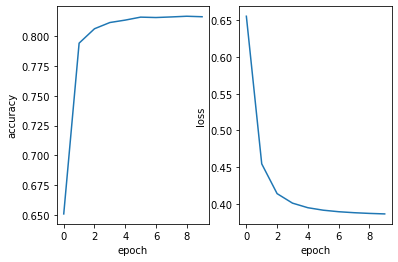

Accuracy on train data: 81.62
Loss on train data: 0.39
Validation on test data: 83.0
--------------------------------------------
Method name: Univariate Selection
Relevant features: ['HAST', 'AAST', 'ADREB', 'HDREB', 'HFGM', 'AFGM', 'AFG3M']


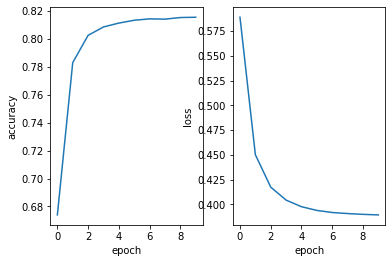

Accuracy on train data: 81.56
Loss on train data: 0.39
Validation on test data: 82.51
--------------------------------------------
Method name: Recursive Feature Elimination
Relevant features: ['HFGM', 'HFG3M', 'HFG3_PCT', 'HFTM', 'AFGM', 'AFG3M', 'AFTM']


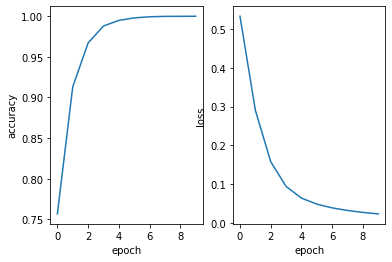

Accuracy on train data: 100.0
Loss on train data: 0.02
Validation on test data: 97.93
--------------------------------------------
Method name: Feature Importance
Relevant features: ['AFG_PCT', 'HFG_PCT', 'HFGM', 'AFGM', 'ADREB', 'HAST', 'HREB']


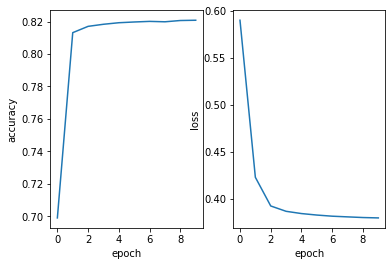

Accuracy on train data: 82.08
Loss on train data: 0.38
Validation on test data: 82.88
--------------------------------------------


In [12]:
# compare 
for method_name, features in methods.items():
    print("Method name: {}".format(method_name))
    print("Relevant features: {}".format(features))
    # using only relevant features in dataset
    X_train_dataset = X_train[features]
    X_test_dataset = X_test[features]
    # creating neural network model
    model = Sequential()
    model.add(Dense(len(features), input_dim=len(features), activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # standarizing data
    scaler = StandardScaler()
    scaled_X_train= scaler.fit_transform(X_train_dataset)
    scaled_X_test = scaler.fit_transform(X_test_dataset)
    # encode class values as integer
    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_Y_train = encoder.transform(y_train)
    # converting integers to dummy variables
    dummy_y_train = np_utils.to_categorical(encoded_Y_train)
    # fitting model with prepared data
    res = model.fit(scaled_X_train, dummy_y_train, epochs=10, batch_size=100, verbose=0)
    accuracy = res.history['accuracy'][-1]
    loss = res.history['loss'][-1]
    #plot accuracy
    plt.subplot(1,2,1)
    plt.plot(res.history['accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #plot loss
    plt.subplot(1,2,2)
    plt.plot(res.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    print("Accuracy on train data: {}".format(round(accuracy*100, 2)))
    print("Loss on train data: {}".format(round(loss, 2)))
    # preparing test labels
    encoder.fit(y_test)
    encoded_Y_test = encoder.transform(y_test)
    dummy_y_test = np_utils.to_categorical(encoded_Y_test)
    # evaluating the model with test data
    scores = model.evaluate(scaled_X_test, dummy_y_test, verbose=0)
    validation = scores[1]
    print("Validation on test data: {}".format(round(validation*100, 2)))
    print("--------------------------------------------")

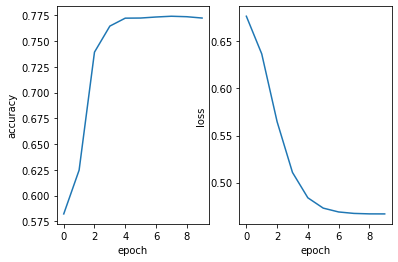

Accuracy on train data: 77.25
Loss on train data: 0.47
Validation on test data: 77.15
--------------------------------------------


In [13]:
# bonus - PCA
from sklearn.decomposition import PCA
from sklearn import preprocessing
# get root datasets
X_train_dataset = X_train
X_test_dataset = X_test
# normalize data before PCA application
X_train = preprocessing.normalize(X_train_dataset)
X_test = preprocessing.normalize(X_test_dataset)
# standarize data before PCA application
#scaler = StandardScaler()
#X_train= scaler.fit_transform(X_train_dataset)
#X_test = scaler.fit_transform(X_test_dataset)
# PCA magic
pca = PCA(n_components=7)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
# create neural network model
model = Sequential()
model.add(Dense(7, input_dim=7, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# encode class values as integer
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y_train = encoder.transform(y_train)
# converting integers to dummy variables
dummy_y_train = np_utils.to_categorical(encoded_Y_train)
# fitting model with prepared data
res = model.fit(X_train, dummy_y_train, epochs=10, batch_size=100, verbose=0)
accuracy = res.history['accuracy'][-1]
loss = res.history['loss'][-1]
#plot accuracy
plt.subplot(1,2,1)
plt.plot(res.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plot loss
plt.subplot(1,2,2)
plt.plot(res.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
print("Accuracy on train data: {}".format(round(accuracy*100, 2)))
print("Loss on train data: {}".format(round(loss, 2)))
# preparing test labels
encoder.fit(y_test)
encoded_Y_test = encoder.transform(y_test)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
# evaluating the model with test data
scores = model.evaluate(X_test, dummy_y_test, verbose=0)
validation = scores[1]
print("Validation on test data: {}".format(round(validation*100, 2)))
print("--------------------------------------------")